In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

## Regression with BIWI head pose dataset

In this problem, we try to find the centre of the head in each image. The dataset to be used is the [BIWI head pose dataset](https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz). For some reason, I can't open the original link, so I just quoted the fastai version where the images have been formatted to jpeg.

#### Let's first get the data

In [4]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [5]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [6]:
fname = '09/frame_00667_rgb.jpg'

In [7]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

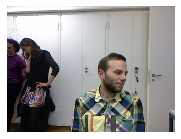

In [8]:

img = open_image(path/fname)
img.show()


In [9]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [10]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [11]:
get_ctr(fname)

tensor([263.9104, 428.5814])

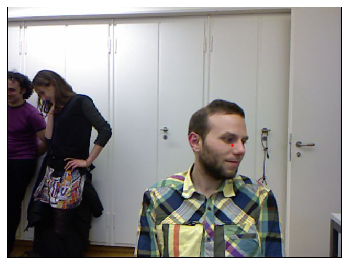

In [12]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

### Disclaimer:
the image processing here is up to the dataset. Jeremy himself isn't completely familiar with them. In any case, it's not really relevant to the deep learning techniques so I'd just leave it as is.

### Crreate a dataset

We note here that the target is to predict the co-ordinates of the centre of a face. You'll see in the above example that the red point corresponds to such co-ordinates. We would like the model to predict this centre. So the model here outputs continuous values and as such works as a regression model.

To this end, we would like the dataset to be points. 
For this we use PointsItemList. The code structure we can see is similar to previous ItemList construction. We pick a separate folder (a separate unseen person) for validation.

In [13]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name == '13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

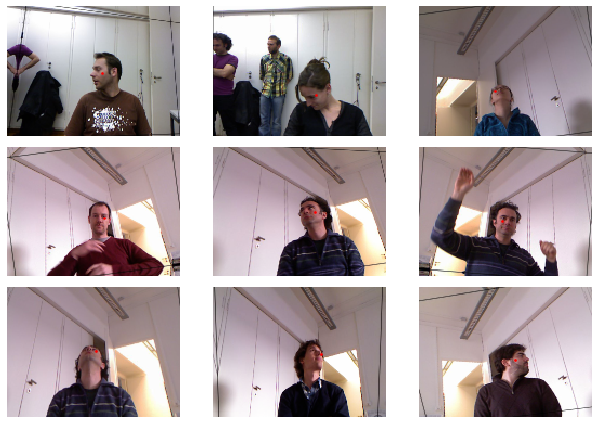

In [14]:
data.show_batch(3, figsize=(9,6))

(one might note the red point position isn't always perfect)

### train model 

We use MSELossFlat() for the regression problem

In [15]:
learn = create_cnn(data, models.resnet34)
learn.loss_func = MSELossFlat()

C:\Users\htngu\Anaconda3\envs\kaggle_pandas\lib\site-packages\fastai\vision\learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


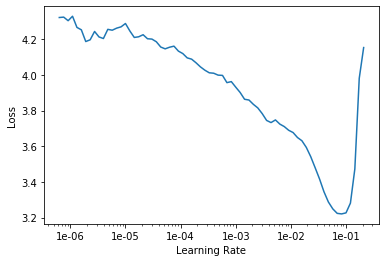

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
lr = 2e-2

In [18]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,0.121213,0.017189,03:01
1,0.041783,0.011624,02:44
2,0.014088,0.002300,02:45
3,0.008403,0.001693,02:44
4,0.006502,0.001348,02:49


In [19]:
learn.save('stage-1-resnet34')

In [ ]:
#learn.load('stage-1-resnet34')

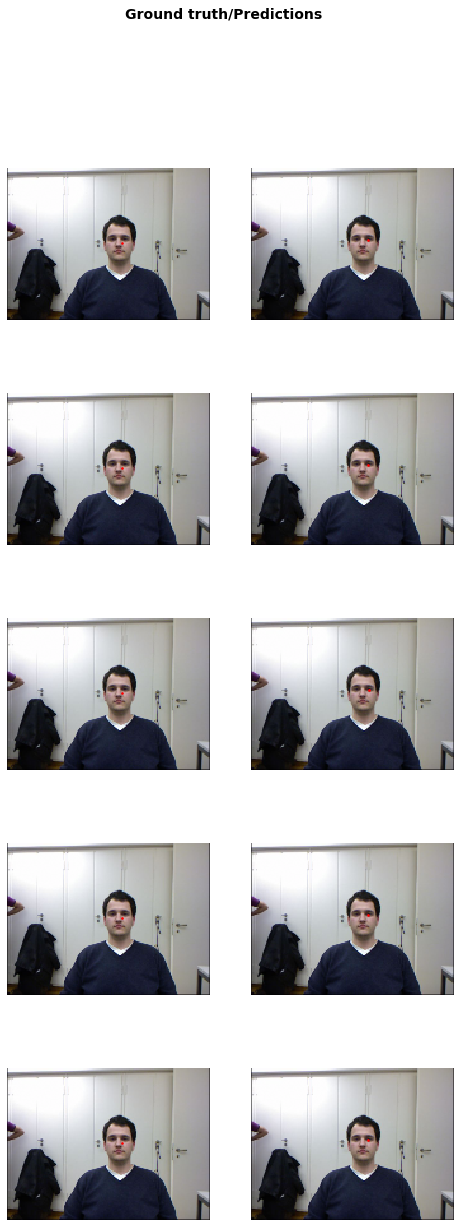

In [20]:
learn.show_results()

### Data augmentation 

In [21]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

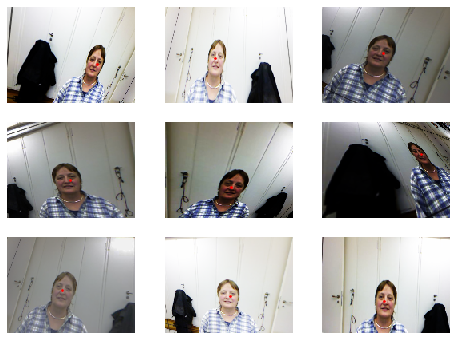

In [22]:


def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))

